<a href="https://colab.research.google.com/github/kdidi99/ml_heidelberg/blob/main/ex5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 5

Team members:

*   Rudolf Braun 
*   Jannik Schacht
*   Kieran Didi

# 5.1 Constructing the matrix X

In [ ]:
import numpy as np
import scipy
from scipy.sparse import coo_matrix
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt

In [ ]:
def construct_X(M, alphas, Np=None):
    # convert alpha from degree to radian
    alphas = np.array(alphas)*np.pi/180
    if not Np: # set Np, if not already defined
        Np = int(M*2**0.5) + 1
    D = M**2
    N0 = len(alphas)
    N = N0*Np
    s0 = (M-1)/2 # offset to centralize the points
    
    Cgrid = np.mgrid[0:M,0:M] # grid to generate the indizes a_j and b_j
    C = np.array([Cgrid[1].flatten()-s0, Cgrid[0].flatten()-s0]) # indizes a_j , b_j centralized
    n = np.array([np.cos(alphas), -np.sin(alphas)]) # normal vector of the sensor
    p = np.transpose(C).dot(n) # projection of the distance on the sensor
    
    # the position of the bin where the projection lies is calculated as float...
    # ... to get the next bin below (round down) and above (round up / round down and add 1)
    # the term np.mgrid[0:D,0:N0][1]*Np corresponds to N_p*i_0, so we get the index i = i_p + N_p*i_0
    Pos = np.transpose(p+(Np-1)/2 + np.mgrid[0:D,0:N0][1]*Np).flatten()
    
    posdown = Pos.astype(int) # positions of the next lower bins
    weightsdown = 1-Pos%1 # the weight is 1-distance
    posup = posdown+1 # positions of the next higher bins
    weightsup = Pos%1 # the weights add up to 1
    
    i_indices = np.array([*posdown, *posup]) # indices of the sensor bins
    j_indices = np.array(list(range(D))*N0*2) # due to the construction of i_indices the j_indices become rather simple
    weights = np.array([*weightsdown, *weightsup]) # corresponding weights
    
    X = scipy.sparse.coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype = np.float32)
    return X

In [ ]:
X = construct_X(M = 10, alphas = [-33, 1, 42], Np = 15)
print(X.shape)

(45, 100)


Matrices equal: False



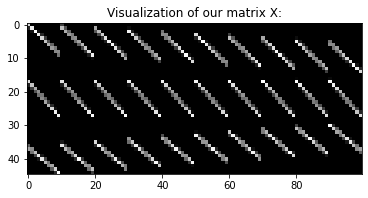

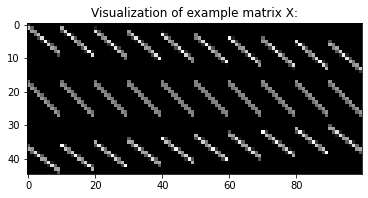

In [ ]:
X_sparse_matrix = construct_X(M = 10, alphas = [-33, 1, 42])
X_array = X_sparse_matrix.toarray()

plt.figure()
plt.gray()
plt.imshow(X_array)
plt.title("Visualization of our matrix X:")

X_example = np.load('X_example.npy')

plt.figure()
plt.gray()
plt.imshow(X_example)
plt.title("Visualization of example matrix X:")

equal = (X_array == X_example).all()
print(f"Matrices equal: {equal}\n")


The structure of both matrices seems to be the same, but they are not exactly equal.

# 5.2 Recovering the image

First, use the smaller version with M = 77 to make debugging easier. 

In [ ]:
# properties of the measurement
M = 77
N_p = 109

# read arrays
y_77 = np.load('y_77.npy')
alphas_77 = np.load('alphas_77.npy')

# calculate X
X_77 = construct_X(M, alphas_77, N_p)

# calculate sparsity
total_elements = X_77.get_shape()[0] * X_77.get_shape()[1]
nonzero_elements = X_77.count_nonzero()
sparsity = (total_elements - nonzero_elements) / total_elements
print(f"X_77 contains {total_elements} elements of which {nonzero_elements} are not zero.")
print(f"This corresponds to a sparsity of {sparsity * 100} %.")

# convert coo_matrix to csc_matrix for solving the linear system efficiently
X_77 = X_77.tocsc()

X_77 contains 58163490 elements of which 1066810 are not zero.
This corresponds to a sparsity of 98.16584252423642 %.


In [ ]:
# use the given version of X_77 for now (until construct_x() works properly)
# X_77 = np.load('X_77.npy', allow_pickle=True)
# X_77 = scipy.sparse.csc_matrix(X_77.all())

In [ ]:
# solve equation to get beta (the flattened tomogram) using scipy
# X * beta = y
tolerance = 1e-05
beta_77 = scipy.sparse.linalg.lsqr(X_77, y_77, atol=tolerance, btol=tolerance)[0]
beta_77.shape

(5929,)

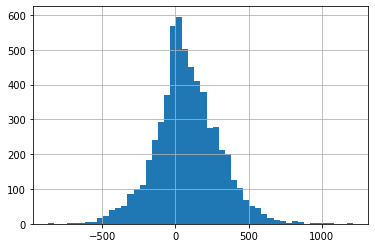

In [ ]:
# plot a histogram to optimize the color scale of the 2D image 
plt.hist(beta_77, 50)
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Tomogram for measurement with M = 77')

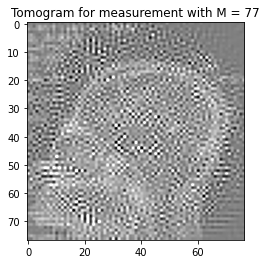

In [ ]:
# convert beta to a 2D image
tomogram_77 = beta_77.reshape((M,M))
plt.figure()
plt.gray()
plt.imshow(tomogram_77, vmin=-500, vmax=500)
plt.title("Tomogram for measurement with M = 77")

Seems like the algorithm is working, so we can now try to compute an image with higher resolution (M = 195).

In [ ]:
# properties of the measurement
M = 195
N_p = 275

# read arrays
y_195 = np.load('y_195.npy')
alphas_195 = np.load('alphas_195.npy')

# calculate X
X_195 = construct_X(M, alphas_195, N_p)

# calculate sparsity
total_elements = X_195.get_shape()[0] * X_195.get_shape()[1]
nonzero_elements = X_195.count_nonzero()
sparsity = (total_elements - nonzero_elements) / total_elements
print(f"X_195 contains {total_elements} elements of which {nonzero_elements} are not zero.")
print(f"This corresponds to a sparsity of {sparsity * 100} %.")

# convert coo_matrix to csc_matrix for solving the linear system efficiently
X_195 = X_195.tocsc()

X_195 contains 1871780625 elements of which 13611991 are not zero.
This corresponds to a sparsity of 99.27277850736381 %.


In [ ]:
# solve equation to get beta (the flattened tomogram) using scipy
# X * beta = y
tolerance = 1e-05
beta_195 = scipy.sparse.linalg.lsqr(X_195, y_195, atol=tolerance, btol=tolerance)[0]
beta_195.shape

(38025,)

Text(0.5, 1.0, 'Tomogram for measurement with M = 195')

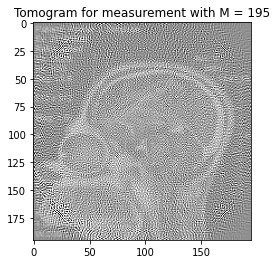

In [ ]:
# convert beta to a 2D image
tomogram_195 = beta_195.reshape((M,M))
plt.figure()
plt.gray()
plt.imshow(tomogram_195, vmin=-500, vmax=500)
plt.title("Tomogram for measurement with M = 195")

With higher resolution, we can now clearly see a head in the tomogram. 

Unfortunately, this image is not detailed enough to give a diagnosis and propose a treatment.

# 5.3 Minimizing the radiation dose

In order to minimize the radiation dose, we try to reduce the number of projection angles that we use for our calculation. 

We don't just cut off half of the alphas_195 array since this wouldn't give good results. Instead, we only consider every i-th element from the alphas_195 array, where i = {2, 4, 6, 8, 10, 12, 14, 16, 18, 20}.

This way we get 10 images with varying number of projection angles.

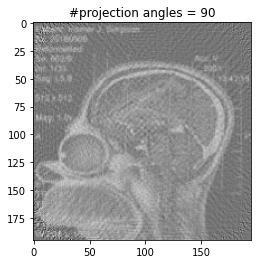

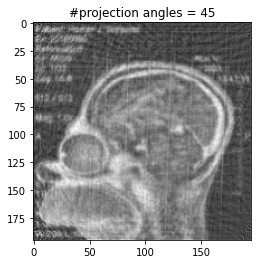

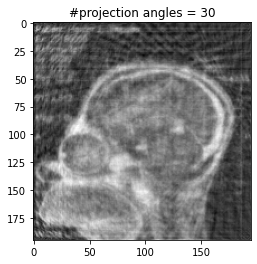

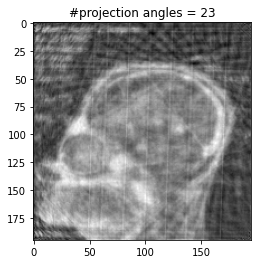

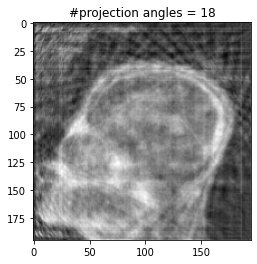

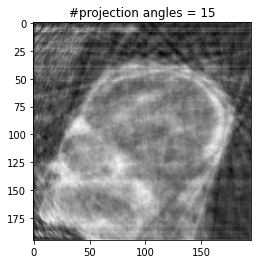

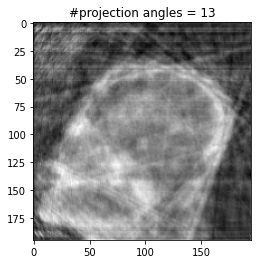

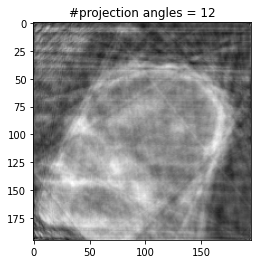

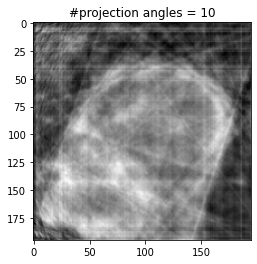

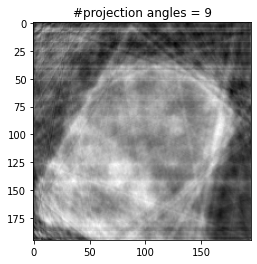

In [ ]:
# properties of the measurement
M = 195
N_p = 275

# calculate and output 2D tomograms for different amounts of projection angles
for i in range(2,21,2):#2

    # reduce number of projection angles to only every i-th
    alphas_195_red = alphas_195[::i]
    y_195_red = y_195.reshape((len(alphas_195), N_p))[::i].flatten()

    # calculate X
    X_195_red = construct_X(M, alphas_195_red, N_p)

    # convert coo_matrix to csc_matrix for solving the linear system efficiently
    X_195_red = X_195_red.tocsc()

    # solve equation to get beta (the flattened tomogram) using scipy
    tolerance = 1e-05
    beta_195_red = scipy.sparse.linalg.lsqr(X_195_red, y_195_red, atol=tolerance, btol=tolerance)[0]

    # convert beta to a 2D image
    tomogram_195_red = beta_195_red.reshape((M,M))
    plt.figure()
    plt.gray()
    plt.imshow(tomogram_195_red)
    plt.title(f"#projection angles = {len(alphas_195_red)}")

Surprisingly, considering 90 projection angles instead of 179 leads to a way better result in our case. The image is less granulated and more detailed. Unfortunately, it still isn't good enough to give a diagnosis.

The image computed with 45 angles is a bit worse, but it can be assumed that it would still be good enough for a diagnosis if the previous ones were good enough for a diagnosis.

Every image computed with less than 45 angles is definitely not good enough, at least in this case.

This means that radiation can be reduced to 50% (or maybe even 25%) of the original amount.